# Autoencoder SC-FC Mapping

Playing around with autoencoders to understand the relationship between SC & FC matrices

This notebook is currently an utter mess. Sorry. 

In [94]:
%matplotlib inline

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

In [95]:
class ConnectomeTransformer:
    
    def __init__(self, n_hidden, alpha = 0.001, l1_ratio = 0.3, lambd = 0.5):
        
        tf.reset_default_graph()
        
        self.n_hidden = n_hidden
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.lambd = lambd
    
    def create_placeholders(self, data, target):
        """
        Create placeholders for data, assuming that the data is provided
        """
        
        self.X = tf.placeholder(name = "X", shape=data.shape, dtype=tf.float32)
        self.target = tf.placeholder(name = "target", shape = target.shape, dtype=tf.float32)

    def initialize_parameters(self):
        
        self.parameters = {}
        
        # Autoencoder
        self.parameters['W0'] = tf.get_variable(
            "W0", 
            [self.X.shape[1], self.n_hidden], 
            initializer = tf.contrib.layers.xavier_initializer(seed = 1), 
            regularizer = tf.contrib.layers.l2_regularizer(scale=self.alpha, scope=None)   
        )
        self.parameters['b0'] = tf.get_variable(
            "b0", 
            [self.X.shape[0],1], 
            initializer = tf.zeros_initializer()
        )
        self.parameters['b1'] = tf.get_variable(
            "b1", 
            [self.X.shape[0], 1], 
            initializer = tf.zeros_initializer()
        )
        
    def forward(self):
        
        # Autoencoder
        self.parameters['A0'] = tf.matmul(self.X, self.parameters['W0']) + self.parameters['b0']
        self.X_prime = tf.matmul(self.parameters['A0'], tf.transpose(self.parameters['W0'])) + self.parameters['b1']

    def compute_cost(self):
        
        l1_regularizer = tf.contrib.layers.l1_regularizer(
           scale=self.alpha, scope=None
        )
        
        l2_regularizer = tf.contrib.layers.l2_regularizer(
           scale=self.alpha, scope=None
        )
        
        weights = [v for v in tf.trainable_variables() if 'b' not in v.name] # all vars of your graph
        
        l1_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)
        l2_penalty = tf.contrib.layers.apply_regularization(l2_regularizer, weights)
        
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        
        self.cost_ = tf.losses.mean_squared_error(self.target, self.X_prime)
        
    def fit(self, data = None,
            target = None,
            n_epochs = 10, 
            learning_rate = 0.0001,
            minibatch_size = 100):
        
        assert data is not None, "You need to provide data."
        
        tf.reset_default_graph()
        
        self.create_placeholders(data, target)
        self.initialize_parameters()
        
        self.forward()
        self.compute_cost()
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost_)
        
        init = tf.global_variables_initializer()
        
        tf.set_random_seed(1)
        with tf.Session() as sess:
            
            sess.run(init)
            for epoch in range(n_epochs):
                _ , cost = sess.run([optimizer, self.cost_], feed_dict={self.X: data, self.target: target})
                if epoch % 100 == 0:
                    print("Epoch %d, cost: %.5f" % (epoch, cost))
            
            self.coef_ = {}
            self.coef_['W0'] = self.parameters['W0'].eval()
            
            self.X_prime = self.X_prime.eval(feed_dict={self.X: data})
            
            """
            self.predicted_ = tf.argmax(tf.nn.softmax(self.parameters['pred_labeled']), axis=1).eval(feed_dict={
                                                                       self.X_labeled: data_labeled,
                                                                       self.Y: y})
            
            correct_prediction = tf.equal(tf.argmax(self.parameters['pred_labeled'], axis = 1), self.Y)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            print ("Train Accuracy:", accuracy.eval({self.X_labeled: data_labeled, self.Y: y}))
            if data_test is not None and y_test is not None:
                print ("Test Accuracy:", accuracy.eval({self.X_labeled: data_test, self.Y: y_test}))
            """

In [96]:
def imageCrop(filename):

    from PIL import Image

    i1 = Image.open(filename)
    i2 = np.array(i1)
    i2[i2.sum(axis=2) == 255*4,:] = 0
    i3 = i2.sum(axis=2)
    x = np.where((i3.sum(axis=1) != 0) * 1)[0]
    y = np.where((i3.sum(axis=0) != 0) * 1)[0]

    result = Image.fromarray(i2[x.squeeze()][:,y.squeeze()])
    result.save(filename)
    
    
def make_mode_surfs_fig(datvec,vtx,tri,n_modes=5,hemi='left',cmap='coolwarm',vmax=None,
                        bg_map=None,darkness=1.5,outfname=None,return_as='array',dpi=300):
                        
  if bg_map is not None: bg_on_data = True
  else:                  bg_on_data = False
            
  if hemi == ('left' or 'right'):
        
    bitmapdat = []
    # Make figs
    
    alldat = []
    for n in range(n_modes):
     
      viewdat = []
      for view in ['lateral', 'medial']:
            
        tmpfname = '/tmp/tmpfig.png'
        fig = plot_surf_stat_map([vtx,tri],datvec[:,n],
                                 hemi=hemi, view=view,cmap=cmap,vmax=vmax,
                                 bg_map=bg_map,darkness=darkness,bg_on_data=bg_on_data);
        plt.savefig(tmpfname,bbox_inches='tight',dpi=dpi)
        plt.close()
        imageCrop(tmpfname)
        viewdat.append(plt.imread(tmpfname))

      # have to match array sizes
      dims = np.array([viewdat[0].shape,viewdat[1].shape])
      mindims = np.min(dims,axis=0)       
      for v_it in range(len(viewdat)): 
        viewdat[v_it] = viewdat[v_it][:mindims[0],:mindims[1],:mindims[2]]
            
      alldat.append(np.concatenate(viewdat, axis=1))

  alldat = np.concatenate(alldat,axis=0)

  if outfname: 
    plt.savefig(outfname, bbox_inches='tight',dpi=dpi)
            
  if return_as == 'array':
    return alldat

  elif return_as == 'plt':
    thisplt = plt.imshow(alldat) 
    plt.axis('off');
    return thisplt

In [97]:
sc33 = np.loadtxt('../scratch/hcp_l2k8_data/100307/HCP_SC_avg_sc33.txt')
np.fill_diagonal(sc33, 0)
sc33 = (sc33 + sc33.T)/2
fc33 = np.loadtxt('../scratch/hcp_l2k8_data/100307/HCP_FC_avg_sc33.txt')

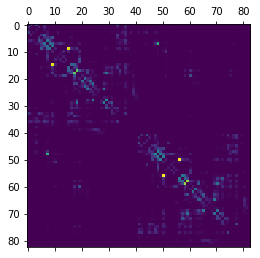

In [98]:
plt.matshow(sc33)

In [107]:
ae1 = ConnectomeTransformer(n_hidden=2)
ae1.fit(data = sc33, target = fc33, n_epochs = 20000)

Epoch 0, cost: 28702.74609
Epoch 100, cost: 22273.51367
Epoch 200, cost: 17640.02148
Epoch 300, cost: 14199.50488
Epoch 400, cost: 11578.28906
Epoch 500, cost: 9542.76367
Epoch 600, cost: 7937.80615
Epoch 700, cost: 6656.08545
Epoch 800, cost: 5621.17090
Epoch 900, cost: 4777.44434
Epoch 1000, cost: 4083.64697
Epoch 1100, cost: 3508.71680
Epoch 1200, cost: 3028.95117
Epoch 1300, cost: 2626.04150
Epoch 1400, cost: 2285.70850
Epoch 1500, cost: 1996.69092
Epoch 1600, cost: 1750.04895
Epoch 1700, cost: 1538.60938
Epoch 1800, cost: 1356.59094
Epoch 1900, cost: 1199.28650
Epoch 2000, cost: 1062.84668
Epoch 2100, cost: 944.10547
Epoch 2200, cost: 840.43976
Epoch 2300, cost: 749.66913
Epoch 2400, cost: 669.96881
Epoch 2500, cost: 599.80688
Epoch 2600, cost: 537.89020
Epoch 2700, cost: 483.12473
Epoch 2800, cost: 434.57880
Epoch 2900, cost: 391.45837
Epoch 3000, cost: 353.08179
Epoch 3100, cost: 318.86514
Epoch 3200, cost: 288.30420
Epoch 3300, cost: 260.96326
Epoch 3400, cost: 236.46489
Epoch 

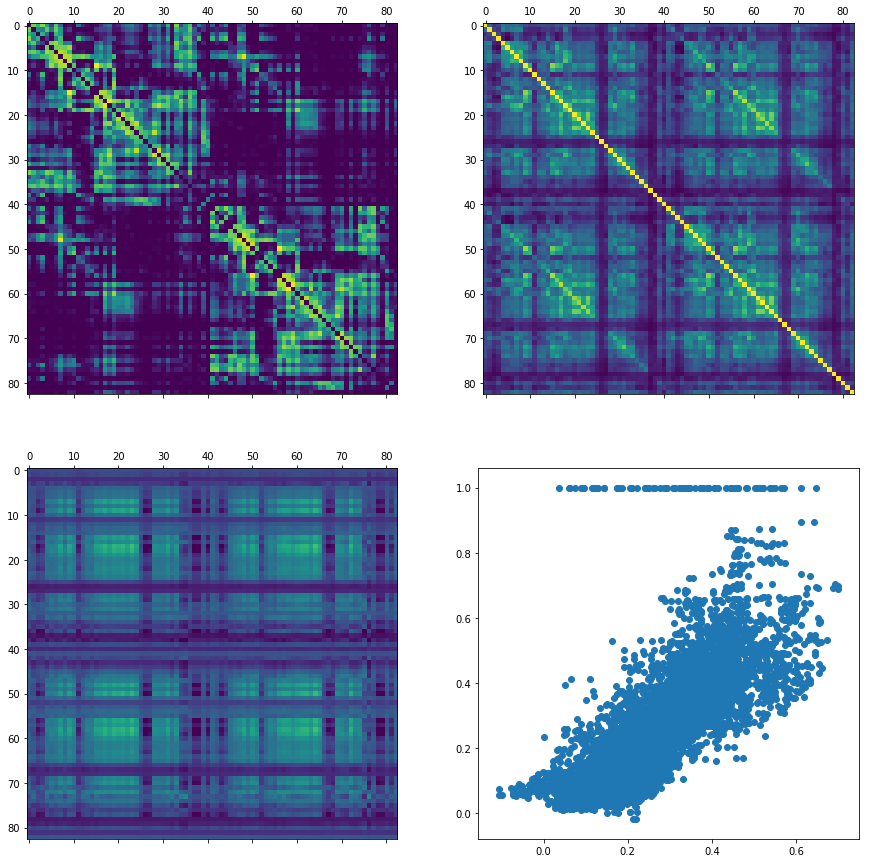

In [130]:
fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(221)
ax.matshow(np.log1p(sc33))

ax = fig.add_subplot(222)
ax.matshow(fc33,vmin=0,vmax=1)

ax = fig.add_subplot(223)
ax.matshow(ae1.X_prime,vmin=0,vmax=1)

ax = fig.add_subplot(224)
ax.scatter(ae1.X_prime, fc33)

In [109]:
np.corrcoef(fc33.ravel(), ae1.X_prime.ravel())

array([[ 1.        ,  0.73782603],
       [ 0.73782603,  1.        ]])

In [113]:
ae2 = ConnectomeTransformer(n_hidden=10)
ae2.fit(data = sc33, target = fc33, n_epochs = 20000)

Epoch 0, cost: 136407.51562
Epoch 100, cost: 104633.26562
Epoch 200, cost: 81828.95312
Epoch 300, cost: 65031.22656
Epoch 400, cost: 52385.00781
Epoch 500, cost: 42693.81250
Epoch 600, cost: 35152.86328
Epoch 700, cost: 29205.95703
Epoch 800, cost: 24460.29102
Epoch 900, cost: 20633.13281
Epoch 1000, cost: 17517.45508
Epoch 1100, cost: 14959.26367
Epoch 1200, cost: 12842.52832
Epoch 1300, cost: 11078.64453
Epoch 1400, cost: 9599.26270
Epoch 1500, cost: 8351.08691
Epoch 1600, cost: 7292.16895
Epoch 1700, cost: 6389.26123
Epoch 1800, cost: 5615.74756
Epoch 1900, cost: 4950.20361
Epoch 2000, cost: 4375.24316
Epoch 2100, cost: 3876.66138
Epoch 2200, cost: 3442.80933
Epoch 2300, cost: 3064.05078
Epoch 2400, cost: 2732.38794
Epoch 2500, cost: 2441.14624
Epoch 2600, cost: 2184.72534
Epoch 2700, cost: 1958.39905
Epoch 2800, cost: 1758.17908
Epoch 2900, cost: 1580.67163
Epoch 3000, cost: 1422.98083
Epoch 3100, cost: 1282.62610
Epoch 3200, cost: 1157.48157
Epoch 3300, cost: 1045.71118
Epoch 3400

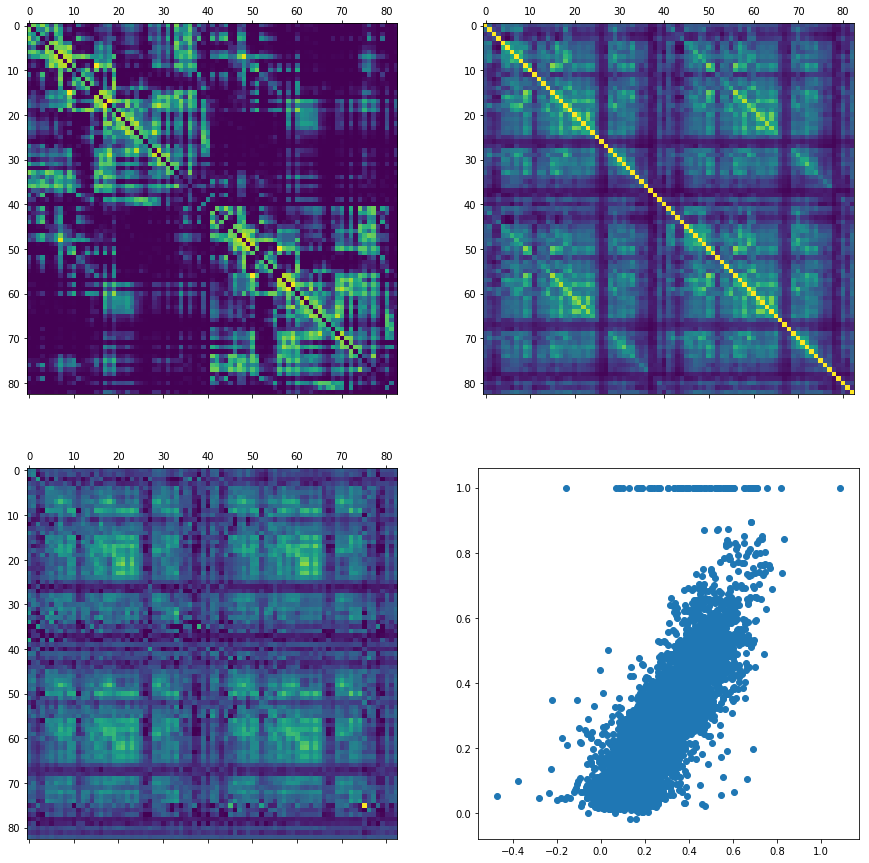

In [131]:
fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(221)
ax.matshow(np.log1p(sc33))

ax = fig.add_subplot(222)
ax.matshow(fc33,vmin=0,vmax=1)

ax = fig.add_subplot(223)
ax.matshow(ae2.X_prime,vmin=0,vmax=1)

ax = fig.add_subplot(224)
ax.scatter(ae2.X_prime, fc33)

In [114]:
np.corrcoef(fc33.ravel(), ae2.X_prime.ravel())


array([[ 1.       ,  0.7806469],
       [ 0.7806469,  1.       ]])

In [115]:
ae3 = ConnectomeTransformer(n_hidden=20)
ae3.fit(data = sc33, target = fc33, n_epochs = 20000)

Epoch 0, cost: 197897.25000
Epoch 100, cost: 143708.96875
Epoch 200, cost: 108370.70312
Epoch 300, cost: 83963.83594
Epoch 400, cost: 66413.86719
Epoch 500, cost: 53413.64453
Epoch 600, cost: 43556.55859
Epoch 700, cost: 35937.91016
Epoch 800, cost: 29952.53125
Epoch 900, cost: 25183.42773
Epoch 1000, cost: 21336.34180
Epoch 1100, cost: 18199.17578
Epoch 1200, cost: 15616.40918
Epoch 1300, cost: 13471.95020
Epoch 1400, cost: 11677.93945
Epoch 1500, cost: 10166.93945
Epoch 1600, cost: 8886.52441
Epoch 1700, cost: 7795.51074
Epoch 1800, cost: 6861.20361
Epoch 1900, cost: 6057.43408
Epoch 2000, cost: 5363.04199
Epoch 2100, cost: 4760.81348
Epoch 2200, cost: 4236.64746
Epoch 2300, cost: 3778.89453
Epoch 2400, cost: 3377.90332
Epoch 2500, cost: 3025.61499
Epoch 2600, cost: 2715.26782
Epoch 2700, cost: 2441.17163
Epoch 2800, cost: 2198.50391
Epoch 2900, cost: 1983.17407
Epoch 3000, cost: 1791.68738
Epoch 3100, cost: 1621.05554
Epoch 3200, cost: 1468.71155
Epoch 3300, cost: 1332.43982
Epoch 3

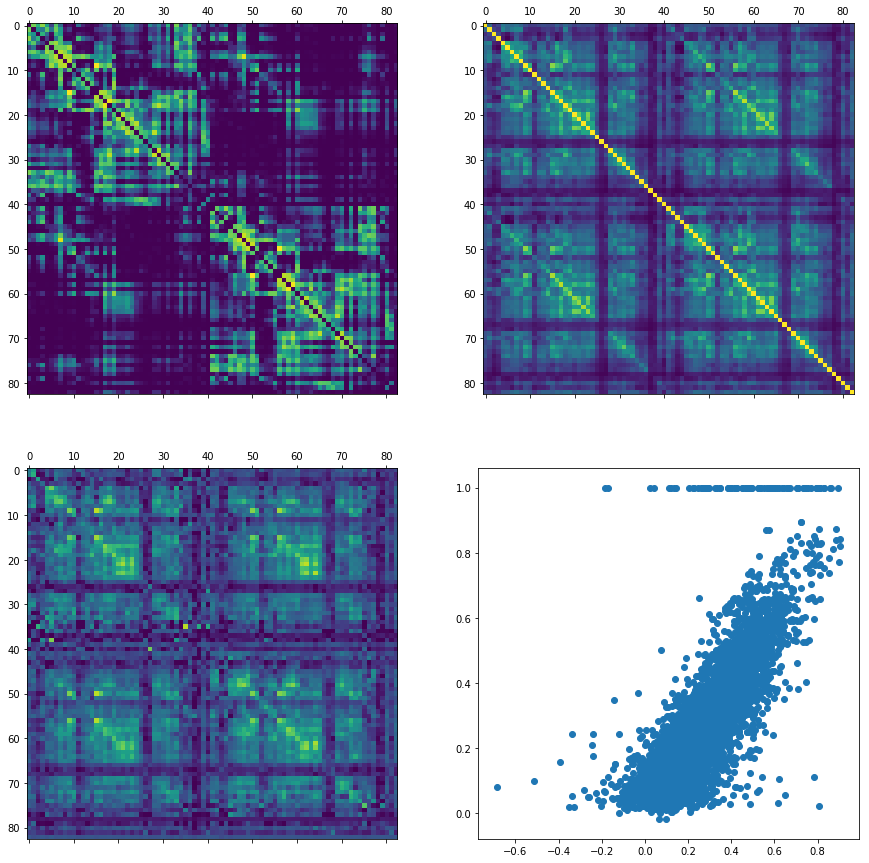

In [132]:
fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(221)
ax.matshow(np.log1p(sc33))

ax = fig.add_subplot(222)
ax.matshow(fc33,vmin=0,vmax=1)

ax = fig.add_subplot(223)
ax.matshow(ae3.X_prime,vmin=0,vmax=1)

ax = fig.add_subplot(224)
ax.scatter(ae3.X_prime, fc33,vmin=0,vmax=1)

In [116]:
np.corrcoef(fc33.ravel(), ae3.X_prime.ravel())

array([[ 1.        ,  0.79910686],
       [ 0.79910686,  1.        ]])

In [119]:
np.corrcoef(fc33.ravel(), ae4.X_prime.ravel())

array([[ 1.        ,  0.77117185],
       [ 0.77117185,  1.        ]])

In [118]:
ae4 = ConnectomeTransformer(n_hidden=100)
ae4.fit(data = sc33, target = fc33, n_epochs = 20000)

Epoch 0, cost: 609154.68750
Epoch 100, cost: 379310.21875
Epoch 200, cost: 258629.92188
Epoch 300, cost: 186249.34375
Epoch 400, cost: 139319.89062
Epoch 500, cost: 107236.82031
Epoch 600, cost: 84426.42188
Epoch 700, cost: 67704.21094
Epoch 800, cost: 55136.25000
Epoch 900, cost: 45492.02344
Epoch 1000, cost: 37959.00391
Epoch 1100, cost: 31984.12500
Epoch 1200, cost: 27181.14258
Epoch 1300, cost: 23274.23828
Epoch 1400, cost: 20062.75977
Epoch 1500, cost: 17398.11719
Epoch 1600, cost: 15168.55176
Epoch 1700, cost: 13288.91016
Epoch 1800, cost: 11693.39746
Epoch 1900, cost: 10330.63867
Epoch 2000, cost: 9160.05469
Epoch 2100, cost: 8149.31787
Epoch 2200, cost: 7272.42139
Epoch 2300, cost: 6508.26904
Epoch 2400, cost: 5839.63770
Epoch 2500, cost: 5252.35938
Epoch 2600, cost: 4734.70117
Epoch 2700, cost: 4276.91211
Epoch 2800, cost: 3870.80103
Epoch 2900, cost: 3509.49854
Epoch 3000, cost: 3187.18774
Epoch 3100, cost: 2898.93481
Epoch 3200, cost: 2640.52441
Epoch 3300, cost: 2408.35425


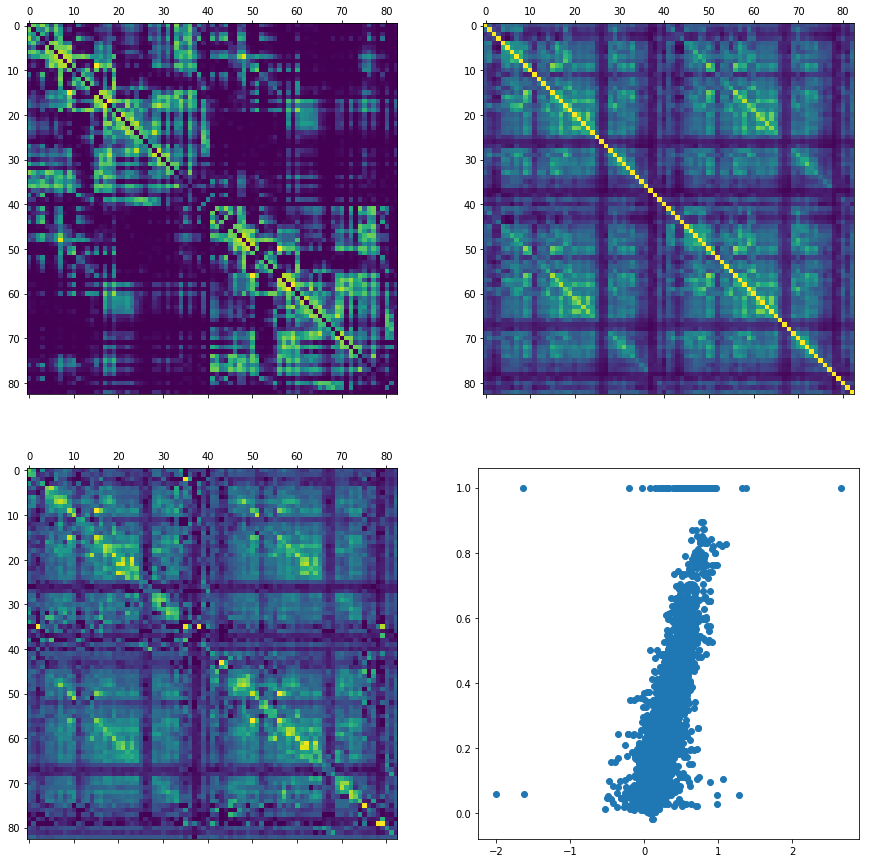

In [134]:
fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(221)
ax.matshow(np.log1p(sc33))

ax = fig.add_subplot(222)
ax.matshow(fc33,vmin=0,vmax=1)

ax = fig.add_subplot(223)
ax.matshow(ae4.X_prime,vmin=0,vmax=1)

ax = fig.add_subplot(224)
ax.scatter(ae4.X_prime, fc33)#,vmin=0,vmax=1)

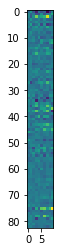

In [16]:
plt.imshow(ae1.coef_['W0'])

In [18]:
import pandas as pd

In [19]:
df_ae1_coef = pd.DataFrame(ae1.coef_['W0'])

In [40]:
df_ae1_coef.shape

(83, 10)

In [22]:
import numpy as np

In [24]:
import nibabel as nib

In [28]:
scales = [33,60,125,250,500]

In [29]:
#f = '/scratch/hpc3230/easy_lausanne_test/easy_lausanne_test/fs/subjects/fsaverage5/surf/lh.inflated'
f = '/mnt/hpcvl-scratch/easy_lausanne_test/easy_lausanne_test/fs/subjects/fsaverage5/surf/lh.inflated'
fsav5_lhi_vtx,fsav5_lhi_tri = nib.freesurfer.read_geometry(f)

f = '/mnt/hpcvl-scratch/easy_lausanne_test/easy_lausanne_test/fs/subjects/fsaverage5/surf/lh.pial'
fsav5_lhp_vtx,fsav5_lhp_tri = nib.freesurfer.read_geometry(f)

f = '/mnt/hpcvl-scratch/easy_lausanne_test/easy_lausanne_test/fs/subjects/fsaverage5/surf/lh.sphere'
fsav5_lhs_vtx,fsav5_lhs_tri = nib.freesurfer.read_geometry(f)

f = '/mnt/hpcvl-scratch/easy_lausanne_test/easy_lausanne_test/fs/subjects/fsaverage5/surf/rh.pial'
fsav5_rhp_vtx,fsav5_rhp_tri = nib.freesurfer.read_geometry(f)

f = '/mnt/hpcvl-scratch/easy_lausanne_test/easy_lausanne_test/fs/subjects/fsaverage5/surf/rh.inflated'
fsav5_rhi_vtx,fsav5_rhi_tri = nib.freesurfer.read_geometry(f)

f = '/mnt/hpcvl-scratch/easy_lausanne_test/easy_lausanne_test/fs/subjects/fsaverage5/surf/rh.sphere'
fsav5_rhs_vtx,fsav5_rhs_tri = nib.freesurfer.read_geometry(f)

fsav5_l2k8_rm_fstr = '/mnt/hpcvl-scratch/Data/tshsothc_data/conmat_matched_fsaverage5_regmap_l2k8_sc%s_%s.txt'

fsav5_l2k8_rms = {(sc,hemi): np.loadtxt(fsav5_l2k8_rm_fstr %(sc,hemi)).astype(int) \
                  for sc in scales for hemi in ['lh', 'rh'] }

fsav5_l2k8_rm_inds = {(sc,hemi): (np.unique(fsav5_l2k8_rms[(sc,hemi)])[1:] -1).astype(int) \
                      for sc in scales for hemi in ['lh', 'rh']}

In [75]:
fsav5_l2k8_rms[(33,'lh')].max()

34

In [76]:
fsav5_l2k8_rm_inds[33,'lh']

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [30]:
sc = 33

In [31]:
lh_inds = fsav5_l2k8_rm_inds[(sc,'lh')]
rh_inds = fsav5_l2k8_rm_inds[(sc,'rh')]

In [39]:
fsav5_l2k8_rms[(sc,'lh')].max()

34

In [78]:
newmat = np.zeros([df_ae1_coef.shape[0]+1,df_ae1_coef.shape[1]])
newmat[1:,:] = df_ae1_coef.values

In [79]:
dat_on_surf = newmat[fsav5_l2k8_rms[(sc,'lh')],:]

In [80]:
from nilearn.plotting import plot_surf_stat_map

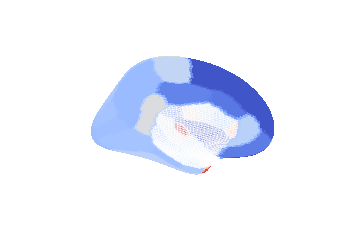

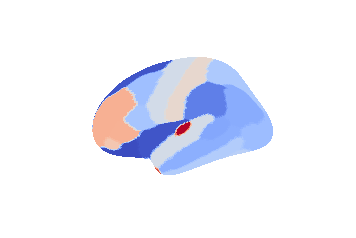

In [85]:
fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,0],
                        hemi='left', view='medial');

fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,0],
                        hemi='left', view='lateral');

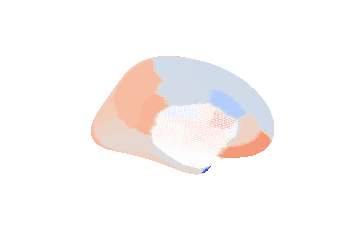

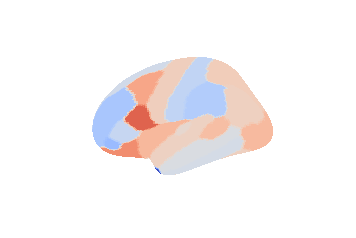

In [86]:
fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,1],
                        hemi='left', view='medial');

fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,1],
                        hemi='left', view='lateral');

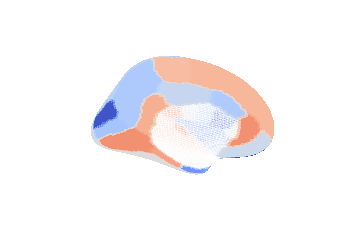

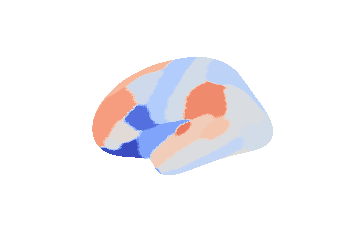

In [87]:
fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,2],
                        hemi='left', view='medial');

fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,2],
                        hemi='left', view='lateral');

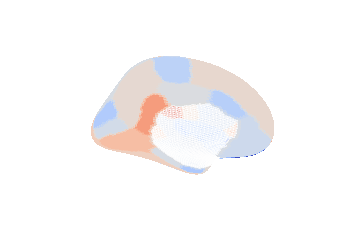

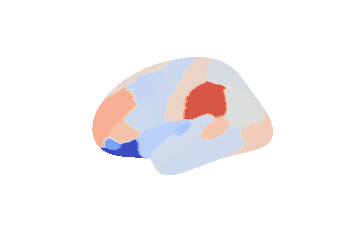

In [88]:
fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,3],
                        hemi='left', view='medial');

fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,3],
                        hemi='left', view='lateral');

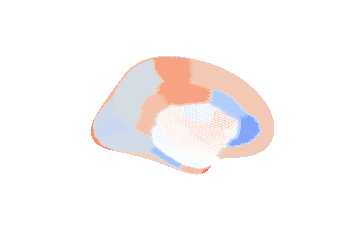

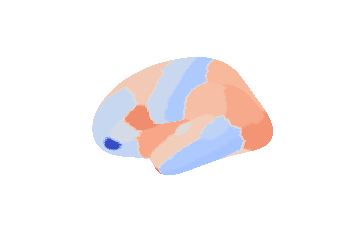

In [89]:
fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,4],
                        hemi='left', view='medial');

fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,4],
                        hemi='left', view='lateral');

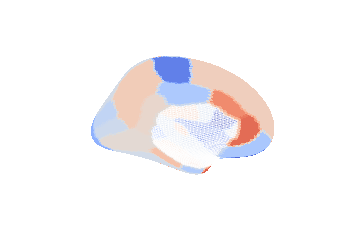

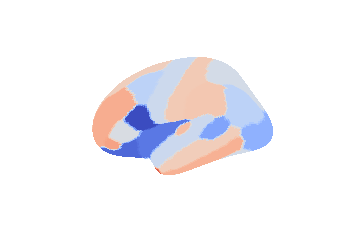

In [90]:
fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,5],
                        hemi='left', view='medial');

fig = plot_surf_stat_map([fsav5_lhi_vtx,fsav5_lhi_tri],dat_on_surf[:,5],
                        hemi='left', view='lateral');

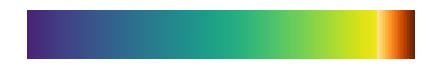

In [67]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('nipy_spectral')
new_cmap = truncate_colormap(cmap, 0.2, 0.95)

#colors1 = plt.cm.YlGnBu(np.linspace(0, 1, 128))
first = int((128*2)-np.round(255*(1.-0.90)))
second = (256-first)
#colors2 = new_cmap(np.linspace(0, 1, first))
colors2 = plt.cm.viridis(np.linspace(0.1, .98, first))
colors3 = plt.cm.YlOrBr(np.linspace(0.25, 1, second))
colors4 = plt.cm.PuBu(np.linspace(0., 0.5, second))
#colors4 = plt.cm.pink(np.linspace(0.9, 1., second))
# combine them and build a new colormap
cols = np.vstack((colors2,colors3))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols)

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=mymap, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()

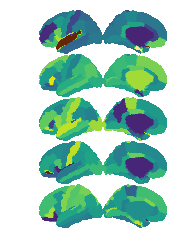

In [70]:
#f = outdir + '/FC_avgs_evecs_on_surf_lh_sc33.png'

fig = make_mode_surfs_fig(dat_on_surf.values,
                    fsav5_lhp_vtx,fsav5_lhp_tri,dpi=600,
                    n_modes=5,hemi='left',cmap=mymap,
                    bg_map=None,darkness=1.5,outfname=None,return_as='plt')
#plt.savefig(f,dpi=600,bbox_inches='tight')

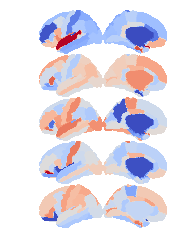

In [71]:
#f = outdir + '/FC_avgs_evecs_on_surf_lh_sc33.png'

fig = make_mode_surfs_fig(dat_on_surf.values,
                    fsav5_lhp_vtx,fsav5_lhp_tri,dpi=600,
                    n_modes=5,hemi='left',cmap='coolwarm',
                    bg_map=None,darkness=1.5,outfname=None,return_as='plt')
#plt.savefig(f,dpi=600,bbox_inches='tight')